Step 1: Build a neural network that will act as a a sign language classifier. The goal is to produce a model that accepts a picture of a hand as input and outputs a letter.

In [1]:
#Import necessary dependencies#
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid', palette='viridis')

from sklearn.metrics import confusion_matrix
import tf2onnx


2023-09-25 18:26:44.491091: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 18:26:45.340295: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-25 18:26:45.344275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 18:26:53.960043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Let's import the dataset#
train_df = pd.read_csv("/home/kiri/ASL_Translator/Data/sign_mnist_train/sign_mnist_train.csv")
test_df = pd.read_csv("/home/kiri/ASL_Translator/Data/sign_mnist_test/sign_mnist_test.csv")

#Print data frames to confirm we've pulled the correct things into the python code#
#print (train_df)
#print (test_df)

y_train = train_df['label']
y_test = test_df['label']
train_df.drop(['label'], axis=1, inplace=True)
test_df.drop(['label'], axis=1, inplace=True)

In [3]:
#Reshape data set
x_train = train_df.values.reshape(train_df.shape[0], 28,28,1)
x_test = test_df.values.reshape(test_df.shape[0], 28,28,1)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)


x_train shape: (27455, 28, 28, 1)
x_test shape: (7172, 28, 28, 1)


/tmp/ipykernel_13143/3006423818.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


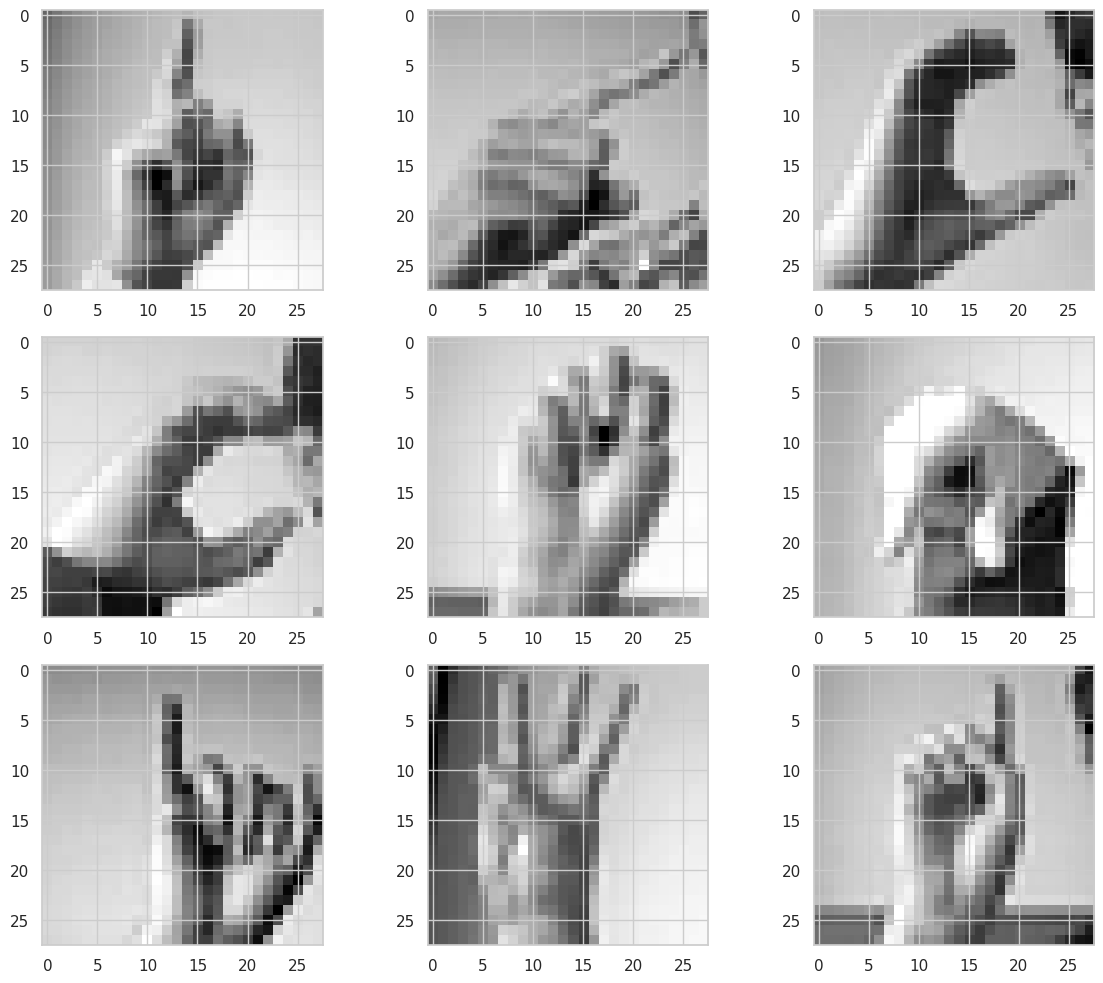

In [4]:
#Plot the first 9 images in the data set#
f, ax = plt.subplots(3,3) 
f.set_size_inches(12, 10)
k = 0
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

This data set is rather small, so let's generate more input by randomly changing the data we do have.

In [5]:
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range = 0.2, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
data_augmentation.fit(x_train)
data_scaled = ImageDataGenerator(rescale=1./255)
x_train, x_test = data_augmentation.flow(x_train, y_train, batch_size=128), data_scaled.flow(x_test, y_test)

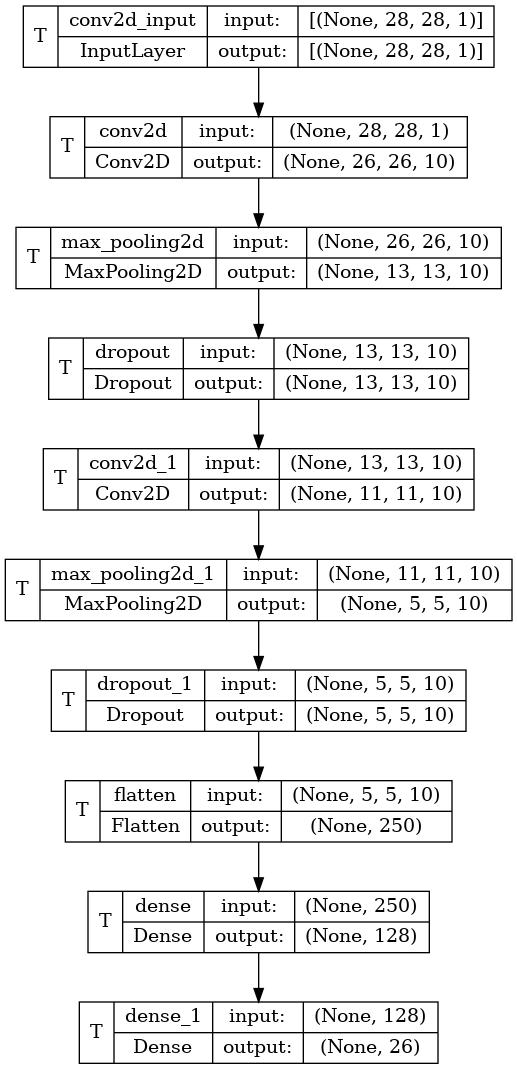

In [6]:
#Build the neural network why build it like this? see Khan and Gondhi, http://cs229.stanford.edu/proj2021spr/report2/81997848.pdf #
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(10, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2), Dropout(0.2),
    tf.keras.layers.Conv2D(10, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(26, activation='softmax') 
])

#these lines of code tell python to plot a figure in the notebook, and then save this as 'model.jpg' showing the neural network#
image_size = (28, 28)
keras.utils.plot_model(model, to_file="model.jpg", show_shapes=True, show_trainable=True)


In [9]:
#Train the model#
epochs=100
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, validation_data=x_test, epochs=epochs)

Epoch 1/100
215/215 [==============================] - 123s 529ms/step - loss: 3.1310 - accuracy: 0.0725 - val_loss: 2.8890 - val_accuracy: 0.1704
Epoch 2/100
215/215 [==============================] - 103s 477ms/step - loss: 2.9068 - accuracy: 0.1334 - val_loss: 2.5193 - val_accuracy: 0.2991
Epoch 3/100
215/215 [==============================] - 122s 567ms/step - loss: 2.7016 - accuracy: 0.1863 - val_loss: 2.1736 - val_accuracy: 0.3565
Epoch 4/100
215/215 [==============================] - 122s 568ms/step - loss: 2.4845 - accuracy: 0.2408 - val_loss: 1.9600 - val_accuracy: 0.4010
Epoch 5/100
215/215 [==============================] - 96s 446ms/step - loss: 2.3288 - accuracy: 0.2808 - val_loss: 1.7416 - val_accuracy: 0.4441
Epoch 6/100
215/215 [==============================] - 86s 400ms/step - loss: 2.1959 - accuracy: 0.3112 - val_loss: 1.6904 - val_accuracy: 0.4635
Epoch 7/100
215/215 [==============================] - 94s 436ms/step - loss: 2.1075 - accuracy: 0.3375 - val_loss: 1.53

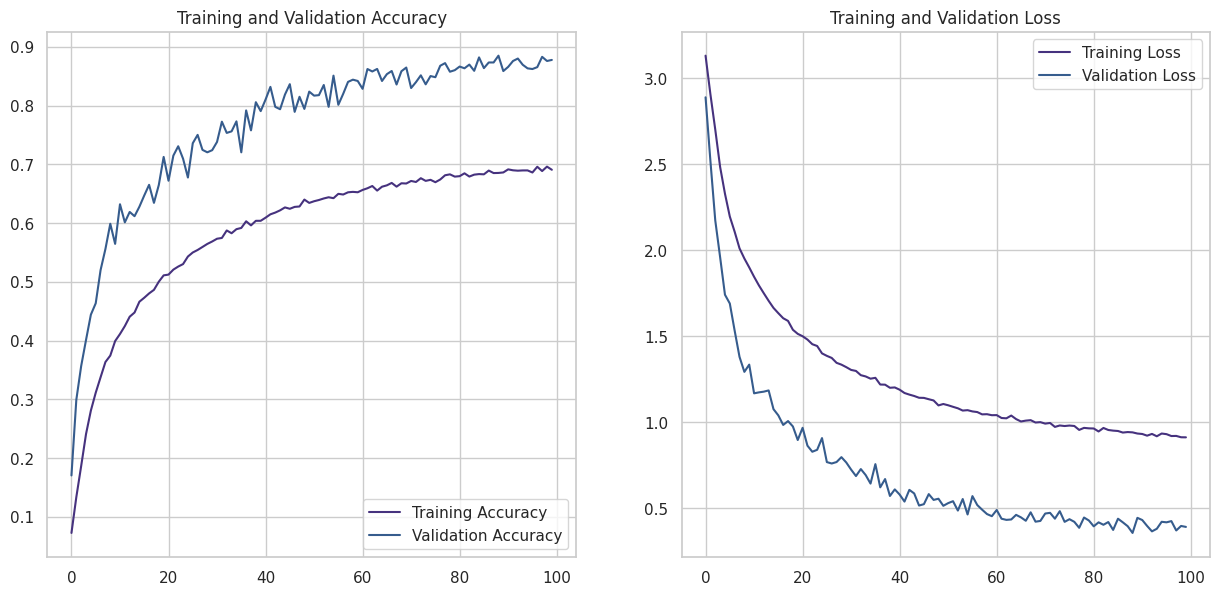

In [10]:
#define parameters for plots - accuracy and loss as a function of training time
accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs_trained = range(len(accuracy))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_trained, accuracy, label='Training Accuracy')
plt.plot(epochs_trained, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 2, 2)
plt.plot(epochs_trained, loss, label='Training Loss')
plt.plot(epochs_trained, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('Accuracy, Loss.png')

In [11]:
#evaluate model against test set
score = model.evaluate(x_test)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])
df_test = pd.read_csv('/home/kiri/ASL_Translator/Data/sign_mnist_test.csv')
y_test = df_test['label']
x_test = test_df.values.reshape(test_df.shape[0], 28,28,1)
df_test.drop(['label'], axis=1, inplace=True)
print("x_test shape:", x_test.shape)
#turn probabilities into actual numbers i.e. labels#
y_pred = np.argmax(model.predict(x_test), axis=1)


225/225 [==============================] - 7s 31ms/step - loss: 0.3921 - accuracy: 0.8777
Test Loss: 0.3920622766017914
Test Accuracy: 0.8777189254760742
x_test shape: (7172, 28, 28, 1)
225/225 [==============================] - 7s 20ms/step


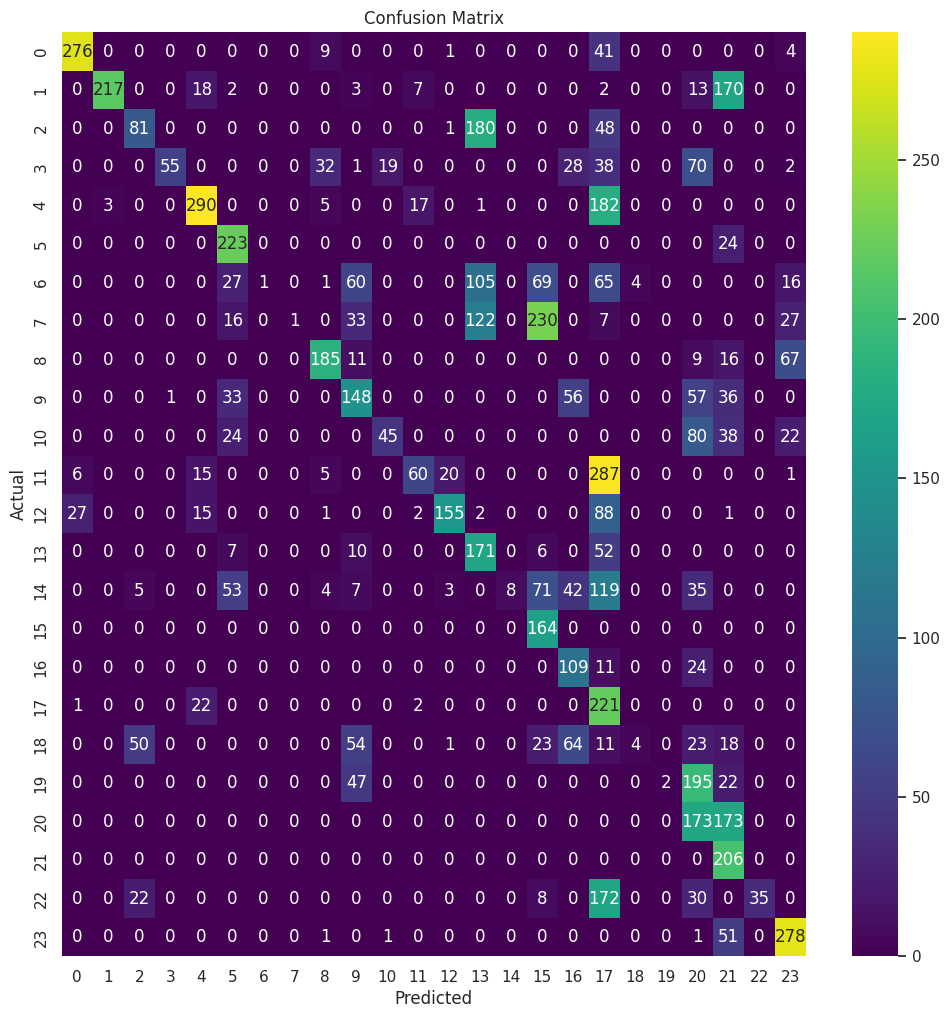

<Figure size 640x480 with 0 Axes>

In [12]:
#plot confusion matrix - literally "the model confuses letter X, with what"
plt.figure(figsize=(12, 12))
sns.heatmap(confusion_matrix(y_test, y_pred), cmap='viridis', annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confusion.png')


In [13]:
#Let's save this model so that we can reload the trained model wheneer we want, without having to go through all the training again
model.save('networkV2.keras')
model.save_weights('network_weights.keras')

#Loading the model
#model.load_weights('network_weights.h5')

# convert to onnx model
import onnx
from tensorflow.keras.models import load_model
keras_model = load_model('/home/kiri/ASL_Translator/networkV2.keras')
onnx_model, _ = tf2onnx.convert.from_keras(keras_model)
output_model_path = "/home/kiri/ASL_Translator/signlanguage.onnx"
# and save the model in ONNX format
onnx.save_model(onnx_model, output_model_path)

Could not search for non-variable resources. Concrete function internal representation may have changed.
2023-09-26 08:14:16.925697: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-09-26 08:14:16.947701: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2023-09-26 08:14:17.397865: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-09-26 08:14:17.398460: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session


In [14]:
import cv2
import onnxruntime as ort
import numpy as np 

def center_crop(frame):
    h, w, _ = frame.shape
    start = abs(h - w) // 2
    if h > w:
        return frame[start: start + w]
    return frame[:, start: start + h]


def main():
    # constants
    index_to_letter = list('ABCDEFGHIKLMNOPQRSTUVWXY')
    mean = 0.485 * 255.
    std = 0.229 * 255.

    # create runnable session with exported model
    ort_session = ort.InferenceSession("signlanguage.onnx", providers=['CPUExecutionProvider'])

    cap = cv2.VideoCapture(0)
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()

        # preprocess data
        frame = center_crop(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        x = cv2.resize(frame, (28, 28))
        x = (x - mean) / std

        x = x.reshape(1, 1, 28, 28).astype(np.float32)
        y = ort_session.run(None, {'input': x})[0]

        index = np.argmax(y, axis=1)
        letter = index_to_letter[int(index)]

        cv2.putText(frame, letter, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 2.0, (0, 255, 0), thickness=2)
        cv2.imshow("Sign Language Translator", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()

[ WARN:0@0.425] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@0.428] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


AttributeError: 'NoneType' object has no attribute 'shape'